In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # visualization library to support seaborn
from dython.nominal import associations
%matplotlib inline

In [2]:
train_df = pd.read_csv('./data/ds-project-train.csv')
val_df = pd.read_csv('./data/ds-project-validation.csv')

/var/folders/ts/n9hl3gns1gz6j1jcwwwg4jjc0000gn/T/ipykernel_11777/2281040594.py:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('./data/ds-project-train.csv')


In [3]:
# Combine the train and val set together since we will do our own splits with cross-validation later
a_df = pd.concat([train_df, val_df])

## Exploratory Data Analysis

In [4]:
# initial summary for dataset
a_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191040 entries, 0 to 47759
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          191040 non-null  int64  
 1   SHIPPER             163385 non-null  object 
 2   SHIPPER.ADDRESS     41338 non-null   object 
 3   CONSIGNEE           175712 non-null  object 
 4   CONSIGNEE.ADDRESS   43670 non-null   object 
 5   ZIPCODE             161276 non-null  object 
 6   NOTIFY              156358 non-null  object 
 7   NOTIFY.ADDRESS      153093 non-null  object 
 8   BILL.OF.LADING      175712 non-null  object 
 9   ARRIVAL.DATE        175712 non-null  object 
 10  WEIGHT..LB.         175712 non-null  float64
 11  WEIGHT..KG.         175712 non-null  float64
 12  US.PORT             175037 non-null  object 
 13  QUANTITY            175712 non-null  float64
 14  Q.UNIT              174713 non-null  object 
 15  MEASUREMENT         175712 non-null  flo

In [5]:
# Gather some interquartile statistics on the target variable for outlier detection and understanding how balanced our classes are
value_counts = a_df['COUNTRY.OF.ORIGIN'].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['COUNTRY.OF.ORIGIN', 'Count']
value_counts_df.describe()

,Count
count,71.000000
mean,2452.014085
std,14858.126877
min,1.000000
25%,8.500000
50%,80.000000
75%,766.500000
max,125366.000000


In [6]:
# Gathert a list of countries that are not well represented in the training set
countries_with_few_samples = list(value_counts_df[value_counts_df['Count'] <= 72 ]['COUNTRY.OF.ORIGIN'])
print(f'The following countries have few samples in the training set {countries_with_few_samples}')

The following countries have few samples in the training set ['Israel', 'Romania', 'Portugal', 'Greece', 'Argentina', 'Jordan', 'Turkey', 'Australia', 'United Arab Em', 'Unknown', 'Peru', 'Morocco', 'Trinidad', 'Bermuda', 'Ecuador', 'Indonesia', 'New Zealand', 'Venezuela', 'Malta', 'Iceland', 'Cambodia', 'Saudi Arabia', 'Denmark', 'Neth Antilles', 'Taiwan', 'US Virgin Is', 'Cayman Isl', 'Guadeloupe', 'Philippines', 'Guam', 'Federal Republic of Germany', 'Belize', 'Kuwait', 'Korea']


In [7]:
# Replace all countries with few samples with other
a_df.loc[a_df['COUNTRY.OF.ORIGIN'].isin(countries_with_few_samples), 'COUNTRY.OF.ORIGIN'] = 'other'
count_othered = len(a_df[a_df['COUNTRY.OF.ORIGIN'] == 'other'])
print(f"Replaced {count_othered} rows COUNTRY.OF.ORIGIN with other")

Replaced 557 rows COUNTRY.OF.ORIGIN with other


In [8]:
# Drop rows where where the target is missing
a_df.dropna(subset=['COUNTRY.OF.ORIGIN'], inplace=True)

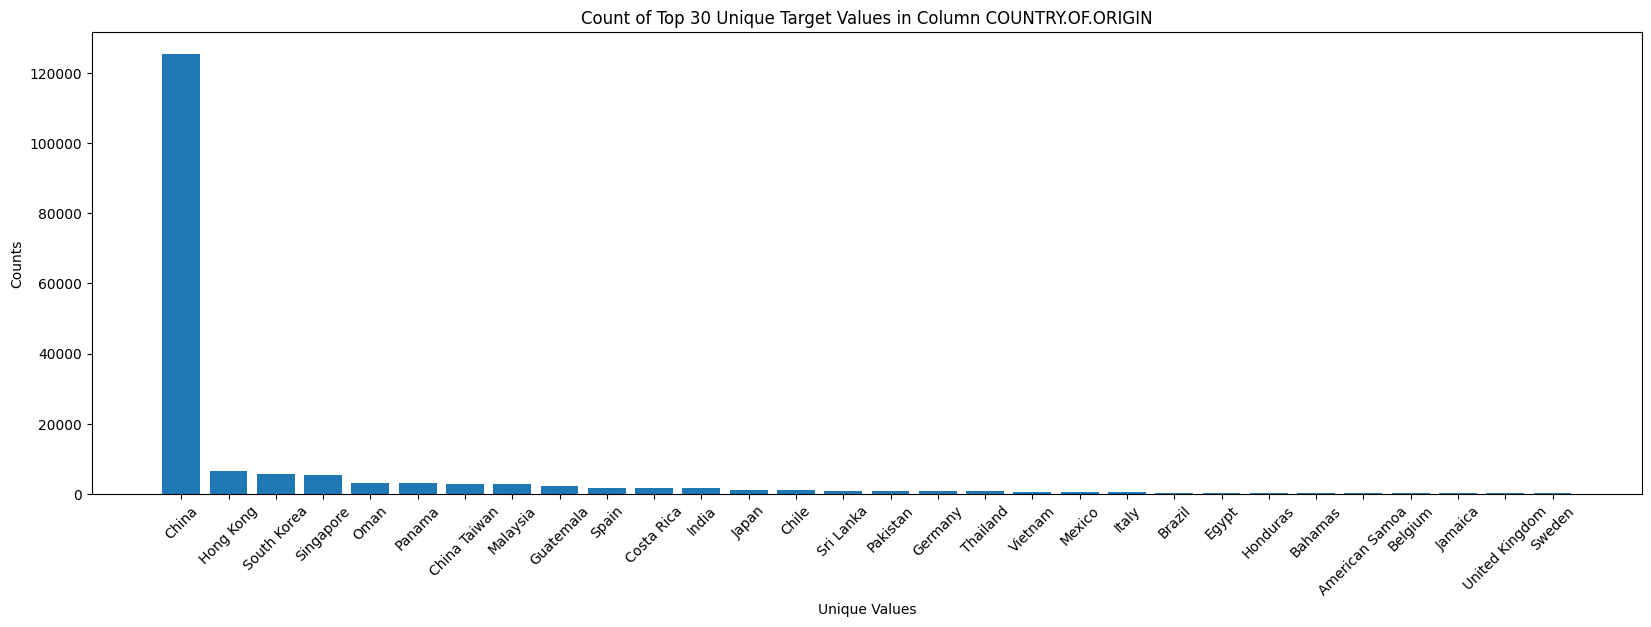

In [9]:
# Go a little deeper on class imbalance to understand how skewed our dataset is
plt.figure(figsize=(20, 6))
plt.bar(value_counts_df['COUNTRY.OF.ORIGIN'].iloc[0:30], value_counts_df['Count'].iloc[0:30])
plt.xticks(rotation=45)
# Adding labels and title
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Count of Top 30 Unique Target Values in Column COUNTRY.OF.ORIGIN')

# Show the plot
plt.show()

It looks like there is a severe class imbalance. We will want to deal with this later.

In [10]:
# Figure out the easy numeric features that are readily available
a_df.select_dtypes(include='number').columns

Index(['Unnamed: 0', 'WEIGHT..LB.', 'WEIGHT..KG.', 'QUANTITY', 'MEASUREMENT',
       'CONTAINER.COUNT'],
      dtype='object')

In [11]:
# Prepare to filter by the top 3 most represented classes to make the plots easier to understand
values_to_include = ['China', 'Hong Kong', 'South Korea']

# Filter the DataFrame to only inlude top 3 target countries
top_3_countries_only_df = a_df[a_df['COUNTRY.OF.ORIGIN'].isin(values_to_include)]

Do some more EDA to understand the relationship between our numerical features and the target variable to get a better sense of how well they correlate.

<Axes: xlabel='COUNTRY.OF.ORIGIN', ylabel='CONTAINER.COUNT'>

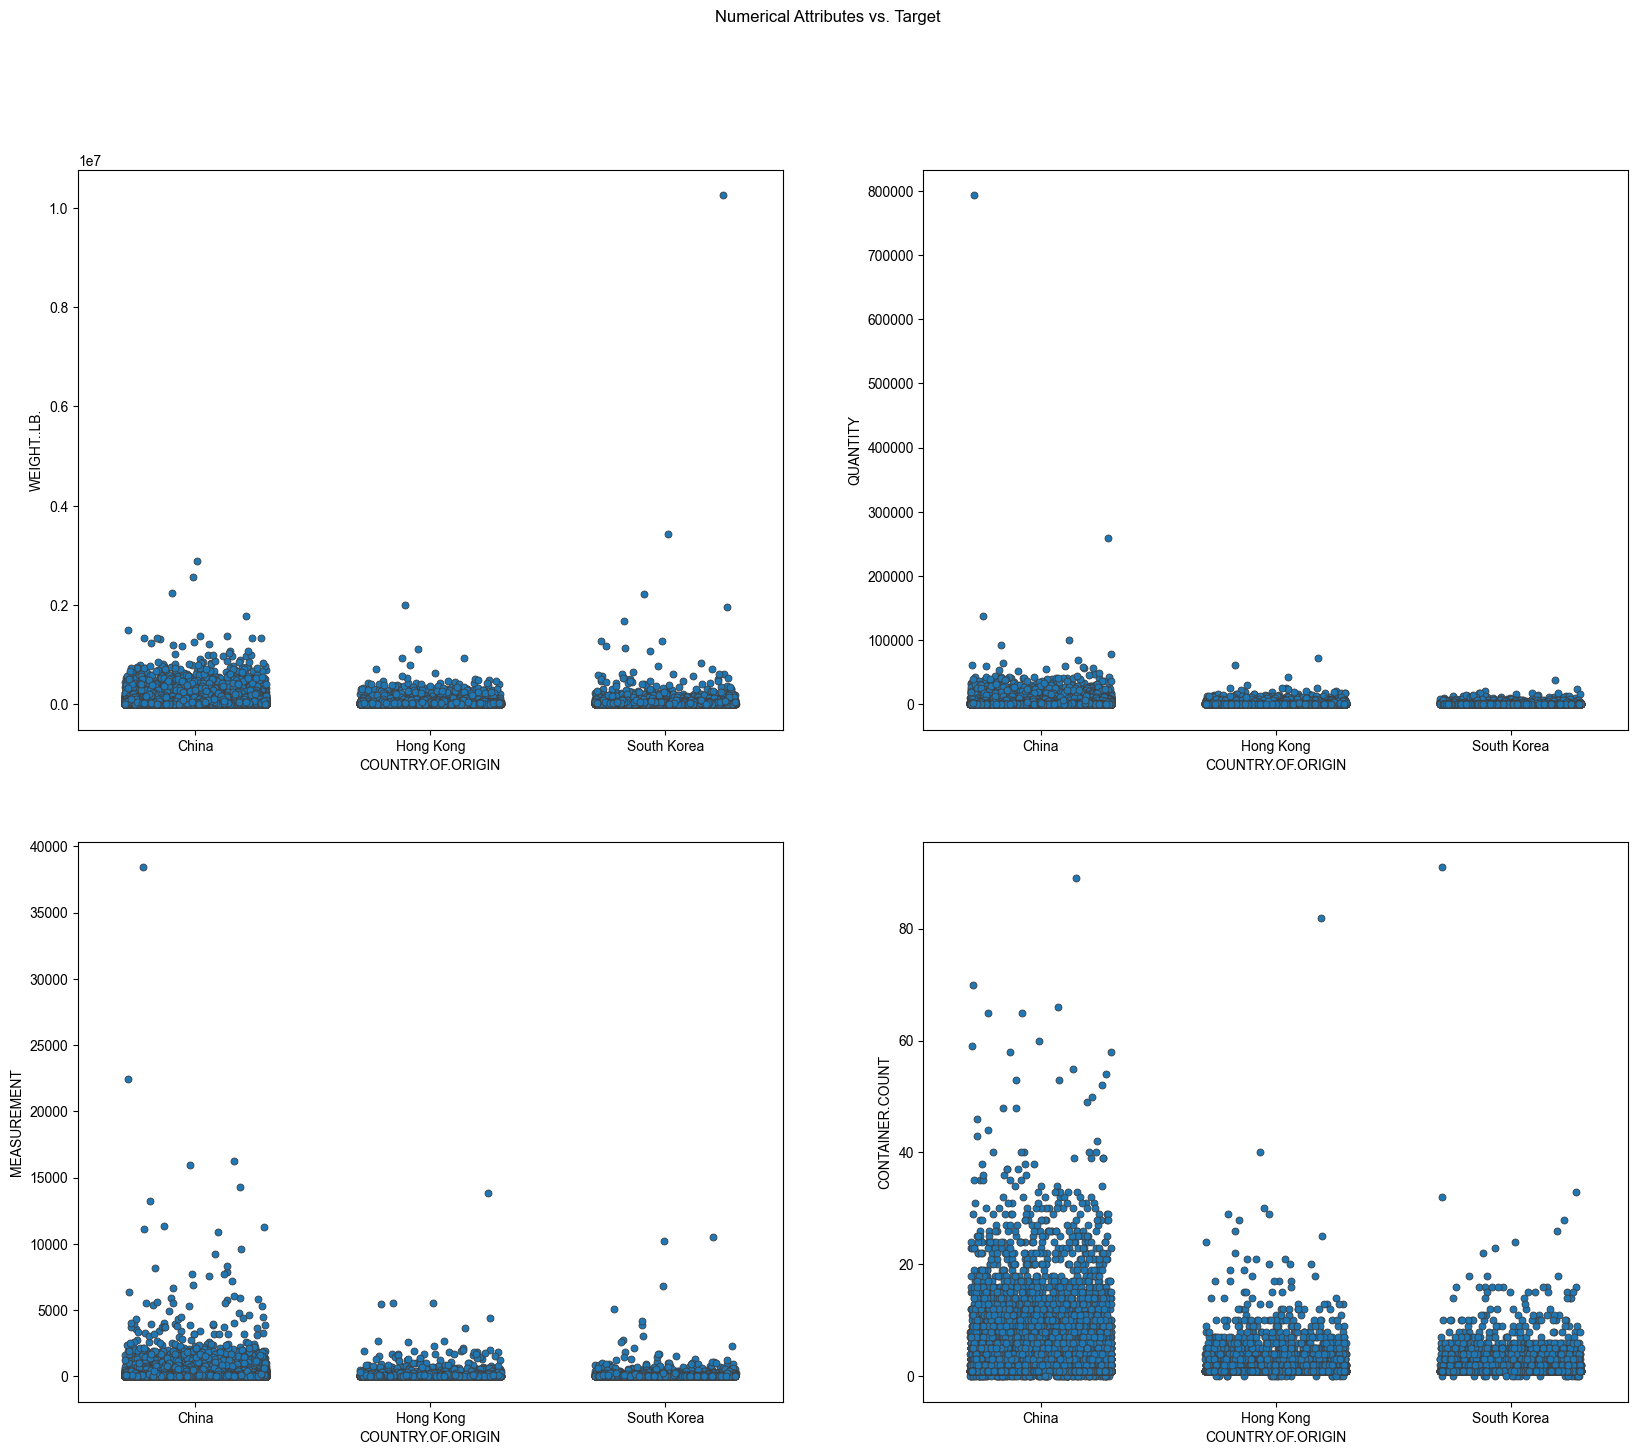

In [12]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_style('whitegrid')

# Comparing various numeric fearures vs. 'target'
sns.stripplot(x=top_3_countries_only_df['COUNTRY.OF.ORIGIN'], y=top_3_countries_only_df['WEIGHT..LB.'], linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
sns.stripplot(x=top_3_countries_only_df['COUNTRY.OF.ORIGIN'], y=top_3_countries_only_df['QUANTITY'], linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
sns.stripplot(x=top_3_countries_only_df['COUNTRY.OF.ORIGIN'], y=top_3_countries_only_df['MEASUREMENT'], linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
sns.stripplot(x=top_3_countries_only_df['COUNTRY.OF.ORIGIN'], y=top_3_countries_only_df['CONTAINER.COUNT'], linewidth=0.6, jitter= 0.3, ax=axes[1, 1])


Now lets just use dython to do a broad corellation analysis and see what features are most correlated with the target variable. If we had more time we could experiment with more extensive feature engineering but this should get us to a good starting point.

/Users/samcooper/Workspace/other/interview/altana/.venv/lib/python3.11/site-packages/dython/nominal.py:708: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
/Users/samcooper/Workspace/other/interview/altana/.venv/lib/python3.11/site-packages/dython/nominal.py:709: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)


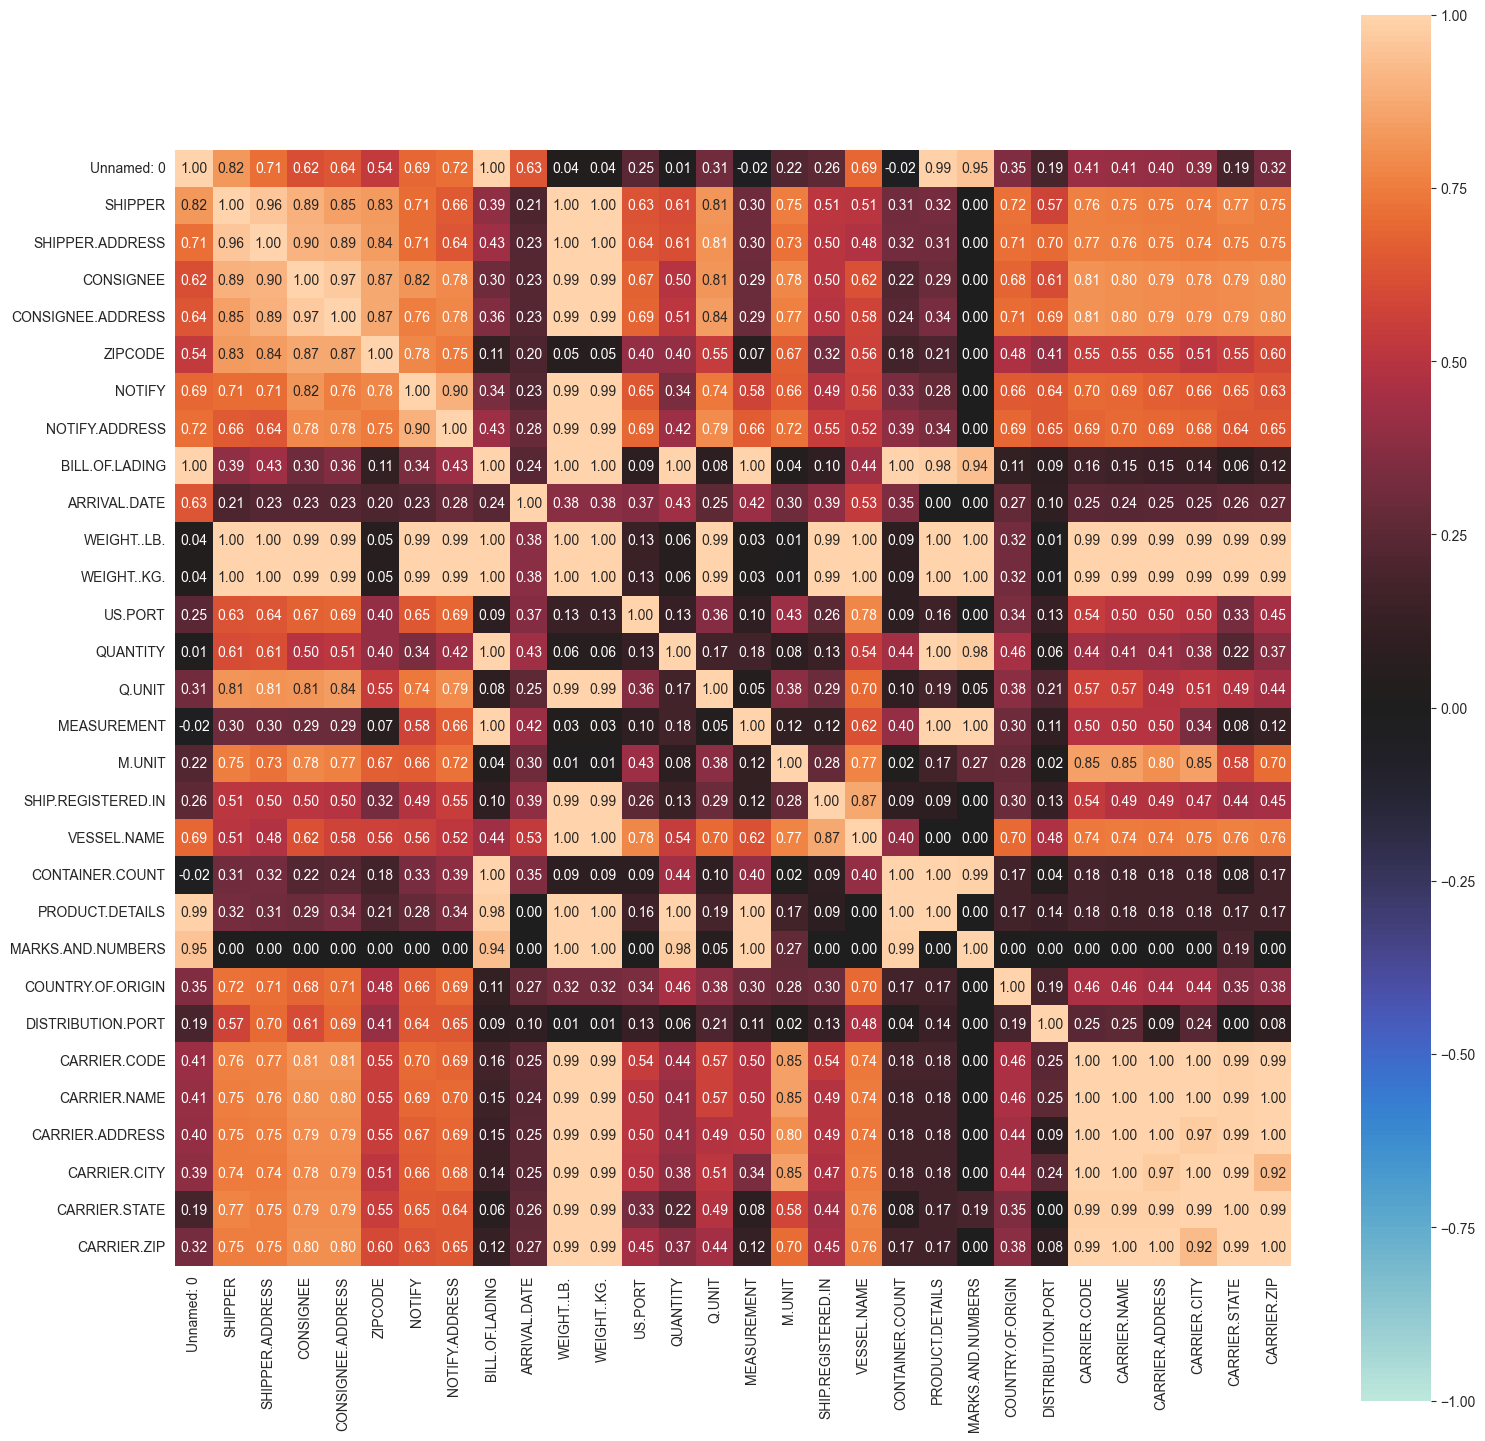

{'corr':                     Unnamed: 0   SHIPPER  SHIPPER.ADDRESS  CONSIGNEE  \
 Unnamed: 0            1.000000  0.821029         0.711633   0.615205   
 SHIPPER               0.821029  1.000000         0.958820   0.891393   
 SHIPPER.ADDRESS       0.711633  0.958820         1.000000   0.900268   
 CONSIGNEE             0.615205  0.891393         0.900268   1.000000   
 CONSIGNEE.ADDRESS     0.639794  0.848076         0.894276   0.968527   
 ZIPCODE               0.536216  0.828404         0.836228   0.873264   
 NOTIFY                0.689775  0.708724         0.708999   0.819137   
 NOTIFY.ADDRESS        0.716966  0.655829         0.638375   0.784361   
 BILL.OF.LADING        1.000000  0.393474         0.434575   0.300705   
 ARRIVAL.DATE          0.633601  0.205355         0.227039   0.228252   
 WEIGHT..LB.           0.037708  0.995241         0.995280   0.994739   
 WEIGHT..KG.           0.037708  0.995241         0.995280   0.994739   
 US.PORT               0.249211  0.627320  

In [13]:
associations(a_df.sample(n=3000, random_state=1), figsize=(18,18))

It looks like there is some strong correlation between the country of origin and the following features: SHIPPER, SHIPPER.ADDRESS, CONSIGNEE, NOTIFY, WEIGHT LB, QUANTIY, Q.UNIT, VESSEL NAME. So lets start by just using these features and see how well we can do.

## Feature preprocessing and engineering

In [14]:
# Filter down the dataframe to the interesting, easy to use, and strongly correlated features only based on the prior analysis
INTERESTING_FEATURES = ['SHIPPER', 'CONSIGNEE', 'NOTIFY', 'WEIGHT..LB.', 'QUANTITY', 'Q.UNIT', 'VESSEL.NAME', 'COUNTRY.OF.ORIGIN']
a_df = a_df[INTERESTING_FEATURES]
a_df

,SHIPPER,CONSIGNEE,NOTIFY,WEIGHT..LB.,QUANTITY,Q.UNIT,VESSEL.NAME,COUNTRY.OF.ORIGIN
0,NaN,-NOT AVAILABLE-,NaN,9273.0,126.0,PCS,CMA CGM NORMA,China
1,NaN,-NOT AVAILABLE-,NaN,18268.8,3292.0,PCS,CMA CGM NORMA,China
2,NaN,-NOT AVAILABLE-,NaN,16280.0,600.0,PCS,CMA CGM NORMA,China
3,NaN,-NOT AVAILABLE-,NaN,17248.0,400.0,PCS,CMA CGM NORMA,China
4,NaN,-NOT AVAILABLE-,NaN,35743.4,1428.0,PCS,CMA CGM NORMA,China
...,...,...,...,...,...,...,...,...
47740,YONG LONG SDN BHD,CROWN MARK INC,CROWN MARK INC,22932.0,568.0,CTN,GJERTRUD MAERSK,Malaysia
47741,YONG LONG SDN BHD,CROWN MARK INC,CROWN MARK INC,22828.0,872.0,CTN,GJERTRUD MAERSK,Malaysia
47742,YONG LONG SDN BHD,CROWN MARK INC,CROWN MARK INC,22795.0,564.0,CTN,MAREN MAERSK,Malaysia
47743,YONG LONG SDN BHD,CROWN MARK INC,CROWN MARK INC,18959.0,540.0,CTN,MAREN MAERSK,Malaysia


In [15]:
# calculating missingess of entire DF
missingness = a_df.isnull().sum().sum() / a_df.count().sum()
print('Overall Missingness is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(a_df)

Overall Missingness is: 2.40%


,Total,Percent
NOTIFY,19332,0.111044
SHIPPER,12327,0.070807
Q.UNIT,997,0.005727
CONSIGNEE,0,0.000000
WEIGHT..LB.,0,0.000000
QUANTITY,0,0.000000
VESSEL.NAME,0,0.000000
COUNTRY.OF.ORIGIN,0,0.000000


In [16]:
# We dont have too many missing values so lets just drop rows with missing values for now. Can use more sophisticated methods of replacement and imputing if time permits later
a_df.dropna(subset=['NOTIFY', 'SHIPPER', 'Q.UNIT'], inplace=True)

In [17]:
# Confirming nothing is missing anymore
missing_table(a_df)

,Total,Percent
SHIPPER,0,0.0
CONSIGNEE,0,0.0
NOTIFY,0,0.0
WEIGHT..LB.,0,0.0
QUANTITY,0,0.0
Q.UNIT,0,0.0
VESSEL.NAME,0,0.0
COUNTRY.OF.ORIGIN,0,0.0


## Model Training and Evaluation

In [18]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

In [19]:
# Pandas get_dummies will give us way too many dimensions - lets just factorize our categoricals to prepare for training
a_df['SHIPPER'] = pd.factorize(a_df['SHIPPER'])[0]
a_df['CONSIGNEE'] = pd.factorize(a_df['CONSIGNEE'])[0]
a_df['NOTIFY'] = pd.factorize(a_df['NOTIFY'])[0]
a_df['Q.UNIT'] = pd.factorize(a_df['Q.UNIT'])[0]
a_df['VESSEL.NAME'] = pd.factorize(a_df['VESSEL.NAME'])[0]
a_df['target'] = pd.factorize(a_df['COUNTRY.OF.ORIGIN'])[0]

In [20]:
# Drop the original column
a_df = a_df.drop('COUNTRY.OF.ORIGIN', axis=1)
a_df

,SHIPPER,CONSIGNEE,NOTIFY,WEIGHT..LB.,QUANTITY,Q.UNIT,VESSEL.NAME,target
9257,0,0,0,54923.0,4734.0,0,0,0
9258,0,0,0,88429.0,6389.0,0,1,0
9259,0,1,1,77107.8,4249.0,0,2,0
9260,0,0,0,214900.4,9668.0,0,3,0
9261,0,0,0,60055.6,2856.0,0,4,0
...,...,...,...,...,...,...,...,...
47740,4640,1879,780,22932.0,568.0,0,541,21
47741,4640,1879,780,22828.0,872.0,0,541,21
47742,4640,1879,780,22795.0,564.0,0,372,21
47743,4640,1879,780,18959.0,540.0,0,372,21


In [21]:
# train and test split --> stratified
X = a_df.drop('target', axis=1).copy()
y = a_df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [22]:
## ---------- XGBoost model v1 ----------
## base run of model with default hyperparameters

xgb_clf1 = xgb.XGBClassifier(objective='multi:softprob', 
                            num_class=a_df.nunique()['target'], 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf1.fit(X_train, 
            y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-merror:0.16614	validation_0-mlogloss:0.89496	validation_1-merror:0.16710	validation_1-mlogloss:0.90160
[1]	validation_0-merror:0.14611	validation_0-mlogloss:0.73118	validation_1-merror:0.15027	validation_1-mlogloss:0.74973
[2]	validation_0-merror:0.13356	validation_0-mlogloss:0.63521	validation_1-merror:0.13868	validation_1-mlogloss:0.65914
[3]	validation_0-merror:0.12577	validation_0-mlogloss:0.57343	validation_1-merror:0.13187	validation_1-mlogloss:0.60206
[4]	validation_0-merror:0.11727	validation_0-mlogloss:0.52458	validation_1-merror:0.12487	validation_1-mlogloss:0.55720
[5]	validation_0-merror:0.11309	validation_0-mlogloss:0.48689	validation_1-merror:0.12064	validation_1-mlogloss:0.52275
[6]	validation_0-merror:0.10922	validation_0-mlogloss:0.45727	validation_1-merror:0.11759	validation_1-mlogloss:0.49595
[7]	validation_0-merror:0.10609	validation_0-mlogloss:0.43149	validation_1-merror:0.11502	validation_1-mlogloss:0.47288
[8]	validation_0-merror:0.10288	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=1,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=37, num_parallel_tree=None, ...)

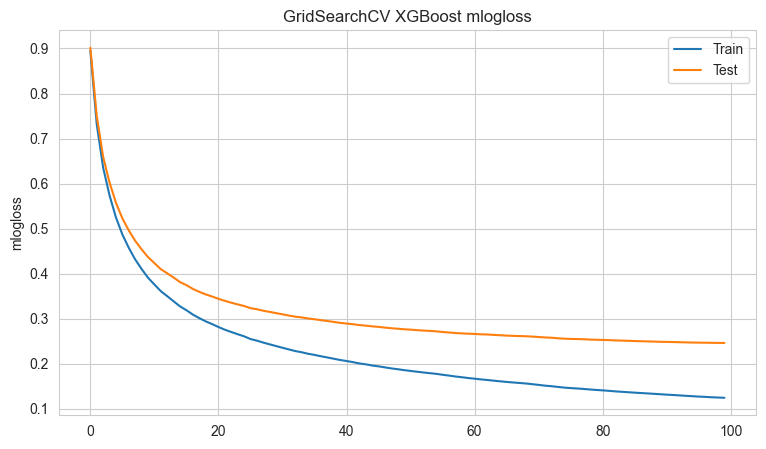

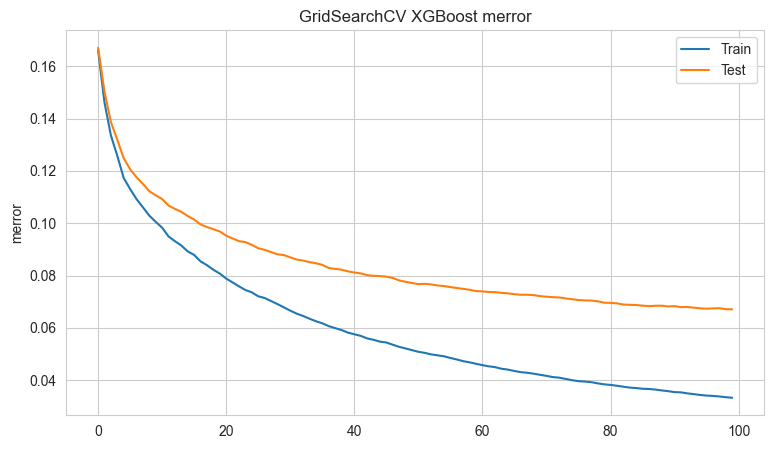

In [23]:
# preparing evaluation metric plots
results = xgb_clf1.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [24]:
## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf1.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling


------------------ Confusion Matrix -----------------

[[  731    38   575 ...     0     0     0]
 [   48  1033   203 ...     2     0     0]
 [   73    58 27639 ...     0     0     0]
 ...
 [    0     2     1 ...    26     0     0]
 [    0     1     0 ...     0    42     0]
 [    0     0     0 ...     0     0    24]]

-------------------- Key Metrics --------------------

Accuracy: 0.93
Balanced Accuracy: 0.78

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.86
Macro Recall: 0.78
Macro F1-score: 0.81

Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1-score: 0.93

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.79      0.50      0.61      1465
           1       0.85      0.77      0.81      1347
           2       0.95      0.99      0.97     27954
           3       0.79      0.71      0.75       671
           4       0.84      0.77      0.80       112
      

[0]	validation_0-merror:0.49181	validation_0-mlogloss:2.36453	validation_1-merror:0.49146	validation_1-mlogloss:2.36597
[1]	validation_0-merror:0.43313	validation_0-mlogloss:2.10749	validation_1-merror:0.43598	validation_1-mlogloss:2.11740
[2]	validation_0-merror:0.43111	validation_0-mlogloss:1.93208	validation_1-merror:0.43655	validation_1-mlogloss:1.94601
[3]	validation_0-merror:0.39679	validation_0-mlogloss:1.77158	validation_1-merror:0.40161	validation_1-mlogloss:1.78982
[4]	validation_0-merror:0.38797	validation_0-mlogloss:1.66916	validation_1-merror:0.39381	validation_1-mlogloss:1.68966
[5]	validation_0-merror:0.36925	validation_0-mlogloss:1.57593	validation_1-merror:0.37530	validation_1-mlogloss:1.59917
[6]	validation_0-merror:0.36896	validation_0-mlogloss:1.51121	validation_1-merror:0.37485	validation_1-mlogloss:1.53626
[7]	validation_0-merror:0.36194	validation_0-mlogloss:1.45094	validation_1-merror:0.36776	validation_1-mlogloss:1.47767
[8]	validation_0-merror:0.35433	validati

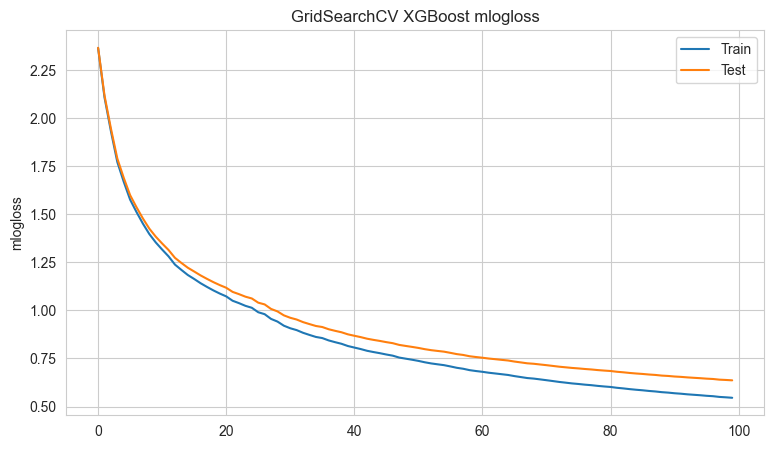

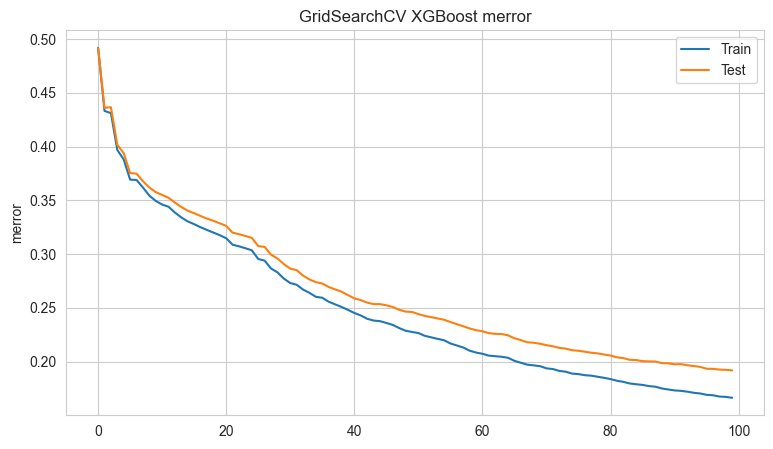


------------------ Confusion Matrix -----------------

[[  899    72   195 ...     0     0     0]
 [   42  1110    40 ...     3     0     0]
 [ 1861   976 22237 ...     1     2     0]
 ...
 [    0     0     0 ...    26     0     0]
 [    0     1     0 ...     0    42     0]
 [    0     0     0 ...     0     0    24]]

Accuracy: 0.81
Balanced Accuracy: 0.83

Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.70
Macro Recall: 0.83
Macro F1-score: 0.74

Weighted Precision: 0.89
Weighted Recall: 0.81
Weighted F1-score: 0.83

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.31      0.61      0.41      1465
           1       0.50      0.82      0.62      1347
           2       0.99      0.80      0.88     27954
           3       0.41      0.84      0.55       671
           4       0.71      0.81      0.76       112
           5       0.71      0.83      0.77        83
       

In [25]:
## ---------- XGBoost model v2 ----------
## second run of model with "optimized" hyperparameters and
## attempting to treat unbalanced target classes

# balancing 'target' class weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf2 = xgb.XGBClassifier(objective='multi:softprob', 
                            num_class=a_df.nunique()['target'], 
                            # missing=1,
                            # gamma=0, # default gamma value
                            # learning_rate=0.1,
                            max_depth=5, # re-optimized from v1
                            reg_lambda=1, # default L2 value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf2.fit(X_train, 
            y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            sample_weight=sample_weights, # class weights to combat unbalanced 'target'
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf2.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

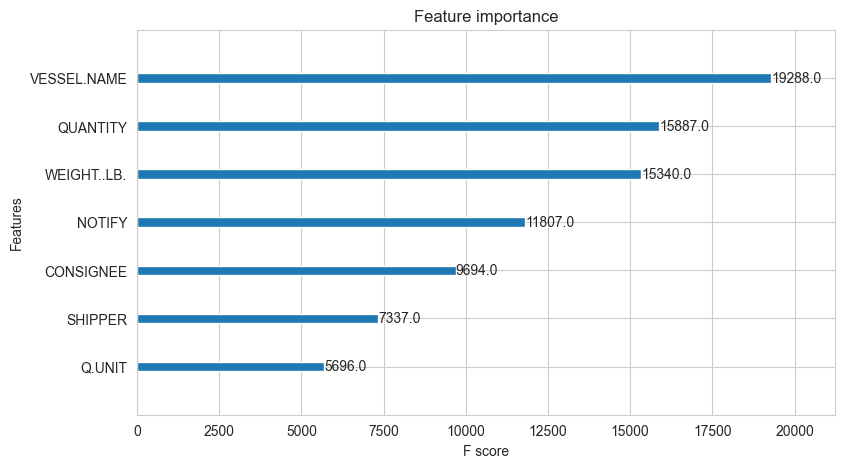

In [26]:
## ---------- Plot Feature Importance ----------
## plotting feature importance of best xgboost model (v1)

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf1, ax=ax)
plt.show()